# Multivariate Hyperbolic Secant Mixture modelの推定
+ モデル:
    + $p(x|w) = \sum_{k=1}^K a_k \prod_{j = 1}^M \frac{\sqrt{s_{kj}}}{2} \frac{1}{\cosh(\frac{s_{kj}}{2}(x_j - b_{kj}))}$
    + $x, b_k \in \mathbb{R}^M, s_k \in \mathbb{R}_+^M$
+ 事前分布:
    + $\varphi(w) = Dir(a|\{ \alpha_k \}_{k=1}^K) \prod_{k=1}^K N(b_k|0, (s_k \beta_k)^{-1} ) Gam(s_k|\gamma_k, \delta_k)$
+ アルゴリズム
   1. 以下の初期化を行う:
       + $g_{ikj}(\eta), v_{ikj}(\eta), h_{ik}(\xi), u_{ik}(\xi)$
   2. 以下を計算する
       + $\hat{\alpha}_k = \alpha_k + \sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\beta}_{kj} = \beta_k + \sum_{i=1}^n -2v_{ikj}(\eta)$
       + $\hat{m}_{kj} = \frac{1}{\hat{\beta}_k} \sum_{i=1}^n -2v_{ik}(\eta)x_i$
       + $\hat{\gamma}_{kj} = \gamma_k + \frac{1}{2}\sum_{i=1}^n u_{ik}(\xi)$
       + $\hat{\delta}_{kj} = \delta_k + \sum_{i=1}^n -v_{ikj}(\eta)x_{ij}^2 - \frac{\hat{\beta}_{kj}}{2}\hat{m}_{kj}^2$
   3. 以下を計算する
       + $g_{ikj}(\eta) = \frac{\hat{\gamma}_{kj}}{\hat{\delta}_{kj}} (x_{ij} - \hat{m}_{kj})^2 + \frac{1}{\hat{\beta}_{kj}}$
       + $v_{ikj}(\eta) = -u_{ik}(\xi)\frac{ \tanh(\sqrt{g_{ikj}(\eta)}/2) }{4\sqrt{g_{ikj}(\eta)}}$
   4. 以下を計算する
       + $h_{ik}(\xi) = \psi(\hat{\alpha}_k) - \psi(\sum_{l=1}^K \hat{\alpha}_l) + \frac{1}{2} \sum_{j=1}^M (\psi(\hat{\gamma}_{kj}) - \log(\hat{\delta}_{kj})) - \sum_{j=1}^M \log(\cosh(\sqrt{g_{ikj}(\eta)}/2)) $
       + $u_{ik}(\xi) = \frac{ \exp(h_{ik}(\xi)) }{ \sum_{l=1}^K \exp(h_{il}(\xi)) }$
       + ここで,$\psi(x) = \frac{d}{dx}\log \Gamma(x)$
   5. 2.に戻る
   
+ 評価関数$\overline{F}_{\xi, \eta}(x^n)$の値
    + $\overline{F}_{\xi, \eta}(x^n) = - \phi(h(\xi)) - \psi(g(\eta)) + u(\xi) \cdot h(\xi) + v(\eta) \cdot g(\eta) $  
        $+ nM \log 2 \pi + \log \Gamma(\sum_{l = 1}^K \hat{\alpha}_l) - \log \Gamma({\sum_{l = 1}^K\alpha}_l) + \sum_{k=1}^K \log \frac{\Gamma(\alpha_k)}{\Gamma(\hat{\alpha}_k)}$  
        $+ \sum_{k=1}^K \sum_{j=1}^M \bigl\{ \frac{1}{2} \log \frac{\hat{\beta}_{kj}}{\beta_{kj}} + \hat{\gamma}_{kj} \log \hat{\delta}_{kj} - \gamma_{kj} \log \delta_{kj} - \log \Gamma(\hat{\gamma}_{kj}) + \log \Gamma(\gamma_{kj}) \bigr\}$

In [2]:
%matplotlib inline

In [3]:
import numpy as np
from scipy.special import gammaln, psi
import matplotlib.pyplot as plt
import seaborn as sns

## HSMMに従う確率変数を生成する

In [6]:
data_seed = 20190514
true_ratio = np.array([0.33, 0.33, 0.34])
true_s = np.array([[2, 2], [0.5, 0.5], [1, 1]])
true_b = np.array([[4, 4], [-4, -4], [0, 0]])
n = 2000
M = true_b.shape[1]
np.random.seed(data_seed)

In [7]:
true_label = np.random.multinomial(n = 1, pvals = true_ratio, size = n)
true_label_arg = np.argmax(true_label, axis = 1)

In [8]:
def random_hsm(n, loc = 0, scale = 1):
    """
    hyperbolic secant distributionに従う確率変数を生成する
    $Y \sim standard_cauchy(x)$の時,  
    $X = \frac{2}{s}\sinh^{-1}(Y) + b$は,  
    $X \sim p(x) = \frac{s}{2\pi}\frac{1}{\cosh(s(x-b)/2)}$に従うはずなので、その確認を行う
    """
    Y = np.random.standard_cauchy(size=n)
    X = 2/np.sqrt(scale)*np.arcsinh(Y) + loc    
    return X

In [9]:
x = np.zeros((n, M))
for i in range(n):
    for j in range(M):
        x[i, j] = random_hsm(n=1, loc=true_b[true_label_arg[i],j], scale=true_s[true_label_arg[i],j])

In [10]:
# from scipy.stats import t
# x = np.zeros((n, M))
# for i in range(n):
#     for j in range(M):
#         x[i, j] = t.rvs(df = 2, loc=true_b[true_label_arg[i],j], scale=true_s[true_label_arg[i],j], size = 1)

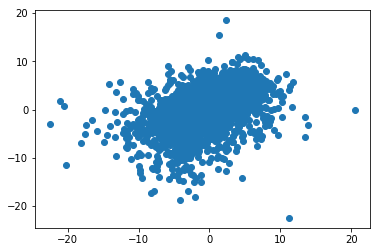

In [7]:
plt.scatter(x[:,0], x[:,1])

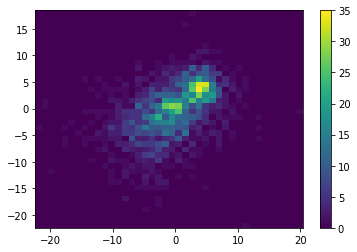

In [8]:
plt.hist2d(x[:,0], x[:,1], bins = 40)
plt.colorbar()
plt.show()

In [9]:
def simple_2dhist(k:int = 0):
    max_val = x.max(axis = 0)
    min_val = x.min(axis = 0)    
    plt.hist2d(x[np.where(true_label_arg == k),0].squeeze(), x[np.where(true_label_arg == k),1].squeeze(), range = [[min_val[0], max_val[0]], [min_val[1], max_val[1]]], bins = 40)
    plt.colorbar()
    plt.xlim(left = min_val[0], right = max_val[0])
    plt.ylim(bottom = min_val[1], top = max_val[1])
    plt.show()
    pass

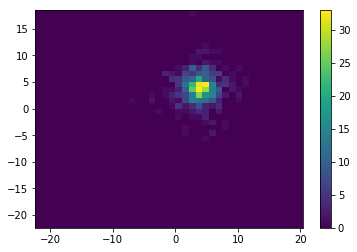

In [10]:
simple_2dhist(0)

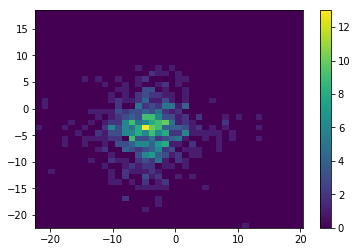

In [11]:
simple_2dhist(1)

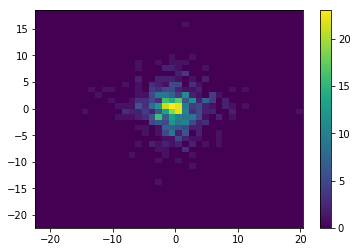

In [12]:
simple_2dhist(2)

# 学習を行う

In [61]:
### 初期設定を行う
iteration = 1000
learning_seed = 20190514

## 学習モデルのコンポーネントの数
K = 5

## ハイパーパラメータ
pri_alpha = 0.1
pri_beta = 0.001
pri_gamma = 2
pri_delta = 2

np.random.seed(learning_seed)

energy = np.zeros(iteration)

In [62]:
### 初期値の設定
est_h_xi = np.random.gamma(shape = 1, size = (n, K))
est_u_xi = np.exp(est_h_xi) / np.repeat(np.exp(est_h_xi).sum(axis = 1), K).reshape(n,K)
# est_u_xi = np.random.dirichlet(alpha = np.ones(K), size=n)

est_g_eta = np.abs(np.random.normal(size=(n,K,M)))
est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))

In [63]:
### 繰り返し計算部分
expand_x = np.repeat(x, K).reshape(n, M, K).transpose((0, 2, 1)) ### n * K * M data with the same matrix among 2nd dimension
for ite in range(iteration):
    ### 事後分布の更新
    est_alpha = pri_alpha + est_u_xi.sum(axis = 0)
    est_beta = pri_beta + (-2*est_v_eta.sum(axis = 0))
    est_m = -2 * (expand_x * est_v_eta).sum(axis = 0) / est_beta
    est_gamma = np.repeat(pri_gamma + est_u_xi.sum(axis = 0)/2, M).reshape(K,M)
    est_delta = pri_delta - (expand_x**2 * est_v_eta).sum(axis = 0) - est_beta / 2 * est_m**2
    ### 対数双曲線関数の更新
    est_g_eta = np.repeat(est_gamma / est_delta, n).reshape(K,M,n).transpose((2,0,1)) * (expand_x - np.repeat(est_m,n).reshape(K,M,n).transpose((2,0,1)))**2 + 1/np.repeat(est_beta, n).reshape(K,M,n).transpose((2,0,1))
    est_v_eta = - np.repeat(est_u_xi, M).reshape(n, K, M) * np.tanh(np.sqrt(est_g_eta)/2)/(4*np.sqrt(est_g_eta))
    
    ### 隠れ変数の更新
    est_h_xi = np.repeat(psi(est_alpha) - psi(est_alpha.sum()) + (psi(est_gamma) - np.log(est_delta)).sum(axis = 1)/2, n).reshape(K,n).T - np.log(np.cosh(np.sqrt(est_g_eta)/2)).sum(axis = 2)
    max_h_xi = est_h_xi.max(axis = 1)
    norm_h_xi = est_h_xi - np.repeat(max_h_xi,K).reshape(n,K)
    est_u_xi = np.exp(norm_h_xi) / np.repeat(np.exp(norm_h_xi).sum(axis = 1), K).reshape(n,K)

    ### エネルギーの計算
    energy[ite] = (np.repeat(est_u_xi, M).reshape(n, K, M) * np.log(np.cosh(np.sqrt(est_g_eta)/2))).sum() - (np.log(np.exp(norm_h_xi).sum(axis = 1)) + max_h_xi).sum() + (est_u_xi * est_h_xi).sum() + (est_v_eta * est_g_eta).sum()
    energy[ite] += gammaln(est_alpha.sum()) - gammaln(K*pri_alpha) + (-gammaln(est_alpha) + gammaln(pri_alpha)).sum()
    energy[ite] += (np.log(est_beta/pri_beta)/2 + est_gamma * np.log(est_delta) - pri_gamma * np.log(pri_delta) - gammaln(est_gamma) + gammaln(pri_gamma)).sum()
print(energy[-1])

4098.458329053392


In [64]:
{
    "est_ratio": est_alpha / est_alpha.sum(),
    "est_b": est_m,
    "est_s": est_gamma / est_delta
}

{'est_ratio': array([0.00049875, 0.33704223, 0.26488721, 0.34545529, 0.05211652]),
 'est_b': array([[ 4.36116330e-12, -8.85390746e-12],
        [ 4.06508742e+00,  3.98625519e+00],
        [-3.42200494e-01,  3.29749909e-01],
        [-4.00369903e+00, -3.71341525e+00],
        [ 1.05865081e+00, -2.56343708e+00]]),
 'est_s': array([[1.        , 1.        ],
        [2.02100792, 1.75115537],
        [1.4502635 , 1.40473725],
        [0.51889133, 0.45228681],
        [0.48801172, 1.31731723]])}